# Sameer Sirsath
# PRN: 202401110023


In [1]:
# CELL 1: IMPORTS & LOAD DATA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv('MBA_ADMISSIONS.csv')
print("✅ Data Loaded:", df.shape)


✅ Data Loaded: (473, 14)


In [2]:
# CELL 2: EXPLORE DATA

print("\n📊 Dataset Info:")
print(df.info())
print("\n📈 Missing Values:", df.isnull().sum().sum())
print("\n📋 Data Summary:")
print(df.describe())



📊 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473 entries, 0 to 472
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   pre_score                     473 non-null    float64
 1   Age_in_years                  473 non-null    int64  
 2   Percentage_in_10_Class        473 non-null    float64
 3   Percentage_in_12_Class        473 non-null    float64
 4   Percentage_in_Under_Graduate  473 non-null    float64
 5   percentage_MBA                473 non-null    float64
 6   post_score                    473 non-null    float64
 7   Gender                        473 non-null    object 
 8   STATE                         473 non-null    object 
 9   Previous_Degree               473 non-null    object 
 10  Marital_status                473 non-null    object 
 11  Place_you_belong_to           473 non-null    object 
 12  perceived#Job#Skill           473 non-null    o

In [3]:
# CELL 3: HANDLE MISSING & ENCODE (CORRECTED)


# Fill missing values (numeric only)
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Label Encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

if 'Gender' in df.columns:
    df['Gender'] = le.fit_transform(df['Gender'])

if 'Marital_status' in df.columns:
    df['Marital_status'] = le.fit_transform(df['Marital_status'])

# One-Hot Encoding
multiclass = ['STATE', 'Previous_Degree', 'Place_you_belong_to', 
              'perceived#Job#Skill', 'Specialization']
df = pd.get_dummies(df, columns=multiclass, drop_first=True)

print(f"✅ Done! Shape: {df.shape}")


✅ Done! Shape: (473, 25)


In [4]:
# CELL 4: PREPARE DATA


# Separate features and target
X = df.drop(['post_score', 'Gender', 'Marital_status'], axis=1).select_dtypes(include=[np.number])
y = df['post_score']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"✅ Train set: {X_train.shape}, Test set: {X_test.shape}")


✅ Train set: (331, 6), Test set: (142, 6)


In [5]:
# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Scaling Done - Mean:", X_train_scaled.mean(), "Std:", X_train_scaled.std())

✅ Scaling Done - Mean: -1.1627713450253403e-17 Std: 1.0


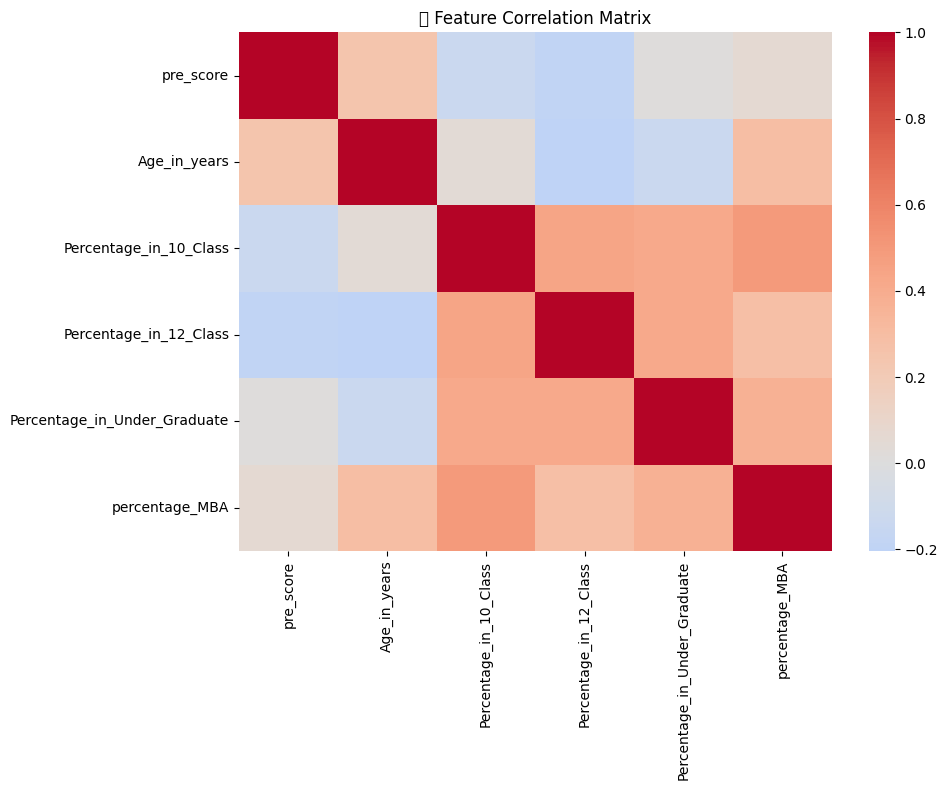

✅ Correlation plot saved


In [6]:
# Correlation matrix
corr = X.corr()

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
plt.title('✅ Feature Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=100)
plt.show()

print("✅ Correlation plot saved")

✅ Selected Features: ['pre_score', 'Age_in_years', 'Percentage_in_10_Class', 'Percentage_in_Under_Graduate', 'percentage_MBA']


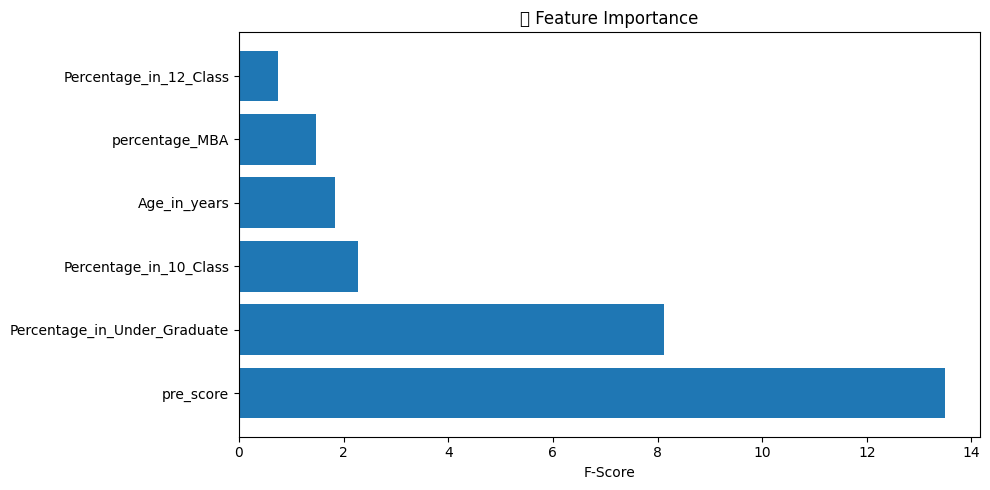

✅ Feature selection plot saved


In [7]:
# SelectKBest - Select top 5 features
selector = SelectKBest(score_func=f_regression, k=5)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Get selected features
selected = X.columns[selector.get_support()].tolist()
print("✅ Selected Features:", selected)

# Plot
scores = pd.DataFrame({'Feature': X.columns, 'Score': selector.scores_})
scores = scores.sort_values('Score', ascending=False).head(8)
plt.figure(figsize=(10, 5))
plt.barh(scores['Feature'], scores['Score'])
plt.xlabel('F-Score')
plt.title('✅ Feature Importance')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=100)
plt.show()

print("✅ Feature selection plot saved")

✅ PCA Variance: 76.33%


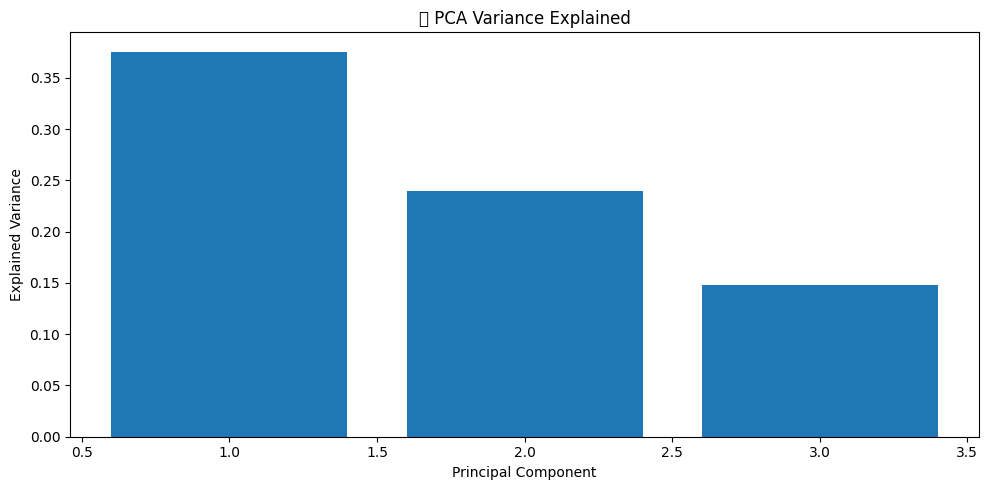

✅ PCA plot saved


In [8]:
# Apply PCA
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

variance = pca.explained_variance_ratio_
print(f"✅ PCA Variance: {variance.sum()*100:.2f}%")

# Plot
plt.figure(figsize=(10, 5))
plt.bar(range(1, len(variance)+1), variance)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('✅ PCA Variance Explained')
plt.tight_layout()
plt.savefig('pca_variance.png', dpi=100)
plt.show()

print("✅ PCA plot saved")

✅ Original: MSE=23.73, R²=0.8525
✅ Scaled: MSE=24.14, R²=0.8499
✅ SelectKBest: MSE=26.06, R²=0.8380
✅ PCA: MSE=40.15, R²=0.7504


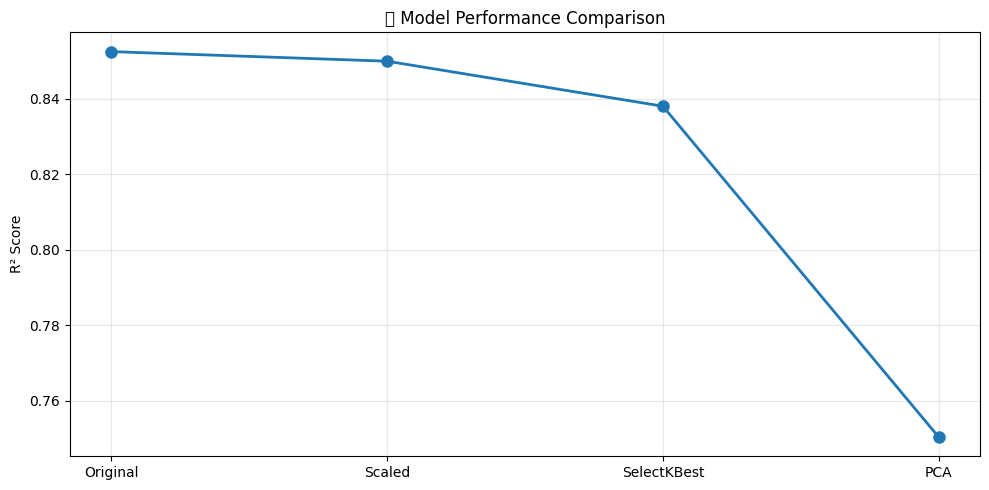


✅ All visualizations saved!


In [9]:
# Train models on different feature sets
models = [
    ('Original', X_train, X_test),
    ('Scaled', X_train_scaled, X_test_scaled),
    ('SelectKBest', X_train_selected, X_test_selected),
    ('PCA', X_train_pca, X_test_pca)
]

results = []
for name, X_tr, X_te in models:
    rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
    rf.fit(X_tr, y_train)
    pred = rf.predict(X_te)
    
    mse = mean_squared_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    
    results.append({'Features': name, 'MSE': mse, 'R²': r2})
    print(f"✅ {name}: MSE={mse:.2f}, R²={r2:.4f}")

# Plot
results_df = pd.DataFrame(results)
plt.figure(figsize=(10, 5))
plt.plot(results_df['Features'], results_df['R²'], marker='o', linewidth=2, markersize=8)
plt.ylabel('R² Score')
plt.title('✅ Model Performance Comparison')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('model_performance.png', dpi=100)
plt.show()

print("\n✅ All visualizations saved!")